## 0. Goal
Run VAE first to reduce spectrogram dimensions from 128*128 to 32 latent features. Then run UMAP and HDBSCAN. <br>
Use Goffinet spectrogramming and VAE network. Use fixed parameters. <br>
Run one bird at a time

In [1]:
import os, sys, importlib, librosa, glob, h5py, tqdm, pickle
from scipy.io import wavfile
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from joblib import Parallel, delayed
import random
import umap, hdbscan
from collections import Counter
import seaborn as sns
from matplotlib.colors import ListedColormap
from sklearn.metrics import silhouette_score
from torch.utils.data import Dataset, DataLoader
import torch
from sklearn.metrics import calinski_harabasz_score

plt.rcParams['pdf.fonttype'] = 42 

In [2]:
# import my utility script
cluster_script_path = '/home/zz367/ProjectsU/EphysMONAO/Jupyter/MatlabCodes/ZZ_callClustering/'
sys.path.insert(1, cluster_script_path)
import hopkins2
import vae_goffinet, hopkins
importlib.reload(vae_goffinet)
importlib.reload(hopkins2)

<module 'hopkins2' from '/home/zz367/ProjectsU/EphysMONAO/Jupyter/MatlabCodes/ZZ_callClustering/hopkins2.py'>

In [3]:
# create a custom colormap for spectrogram
jet = plt.get_cmap('jet', 255)
# Extract jet colors and prepend black at the beginning
jet_colors = jet(np.linspace(0, 1, 255))
custom_colors = np.vstack([[0, 0, 0, 1], jet_colors])  # Black for 0, then jet
custom_cmap = ListedColormap(custom_colors)

## 1. Inputs

In [4]:
fd_z4 = '/mnt/z4'
fd_data = os.path.join(fd_z4, 'zz367', 'EphysMONAO', 'Analyzed', 'vaeWav')
bd = 'pair4RigACU68'
# color limits when calculating spectrograms, depending on the audio amplitude, may differ between birds
clim = [1.5,7]
# what syllable to analyze
syl = ['v']
sylStr = ''.join(syl)
# the default color list
col_list = ['#e41a1c','#a65628','#4daf4a','#984ea3','#ff7f00','#f781bf','#377eb8','#737373']
# what input dataset to use
rn = 'spec_goffinet_nn_256_176'
# size of the spectrogram windows
X_SHAPE = [128, 128]

In [5]:
fd_save = os.path.join(fd_data, bd, 'UMAPonVAE7', sylStr, rn)
if not os.path.exists(fd_save):
    os.makedirs(fd_save)
print(fd_save)

/mnt/z4/zz367/EphysMONAO/Analyzed/vaeWav/pair4RigACU68/UMAPonVAE7/v/spec_goffinet_nn_256_176


In [6]:
# paramteres for UMAP and HDBSCAN
param_umap = {'n_components':2, 'n_neighbors':25, 'min_dist':0, 'metric':'cosine'}
param_hdbscan = {'min_cluster_size_frac':0.05, 'min_samples': 20, 'select_method':'leaf'}

## 2. Train VAE, obtain latent features

In [9]:
print(f'Processing for {bd} {rn}...')
print(f'Save results to {fd_save}')
## load spectrograms and meta info
fn_spec = os.path.join(fd_data, bd, 'Spectrogram2', sylStr, f'{bd}.{sylStr}.{rn}.h5')
fn_info = os.path.join(fd_data, bd, 'Spectrogram2', sylStr, f'{bd}.{sylStr}.{rn}.info.csv')
with h5py.File(fn_spec, 'r') as f:
    spec_win_all = f['spec_win_all'][:]  #

info = pd.read_csv(fn_info, index_col=0)

print(spec_win_all.shape, info.shape)

Processing for pair4RigACU68 spec_goffinet_nn_256_176...
Save results to /mnt/z4/zz367/EphysMONAO/Analyzed/vaeWav/pair4RigACU68/UMAPonVAE7/v/spec_goffinet_nn_256_176
(36359, 128, 128) (36359, 7)


In [10]:
## train VAE network
# create dataloader from h5 file
# train_data = vae_goffinet.SpecDataset(fn_spec)
# # set a random seed
# g = torch.Generator()
# g.manual_seed(42)
# train_dataloader = DataLoader(train_data, batch_size=64, shuffle=True, num_workers=4, generator=g)  # set shuffle to true
# loaders = {'train':train_dataloader, 'test':train_dataloader}

# # init VAE model then train
# model = vae_goffinet.VAE(save_dir=fd_save)
# model.train_loop(loaders, epochs=51, test_freq=None, vis_freq=None, save_freq=10)

# OR load previously trained model
# for training see ZZp3_UMAPonVAE_v1.ipynb
fn_model = os.path.join(fd_save, f'{bd}_checkpoint_final.tar')
model = vae_goffinet.VAE(save_dir=fd_save)
model.load_state(fn_model)

In [11]:
## Obtain latent representation
train_data = vae_goffinet.SpecDataset(fn_spec)
train_dataloader = DataLoader(train_data, batch_size=64, shuffle=False, num_workers=4)  # set shuffle to false to match the order in id_pd

# loop through dataloader, obtain model latent space
latent_m = np.zeros((info.shape[0], 32))
latent_d = np.zeros((info.shape[0], 32))
recon = np.zeros((info.shape[0], X_SHAPE[0], X_SHAPE[1]))
model.eval()
count = 0
for i, data in tqdm.tqdm(enumerate(train_dataloader)):
    data = data.to('cuda:0')
    with torch.no_grad():
        _, _, rec, mu, d = model.forwardZZ(data, return_latent_rec=True)
        a = rec.shape[0]
        latent_m[count:(count+a),:] = mu
        latent_d[count:(count+a),:] = d
        recon[count:(count+a),:,:] = rec
        count += a

# save the latent representations
fn_latentM = os.path.join(fd_save, 'latentM.csv')
np.savetxt(fn_latentM, latent_m, delimiter=',')
fn_latentD = os.path.join(fd_save, 'latentD.csv')
np.savetxt(fn_latentD, latent_d, delimiter=',')
print(latent_m.shape)

0it [00:00, ?it/s]/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/torch/nn/modules/conv.py:952: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv_transpose2d(
569it [00:40, 14.06it/s]


(36359, 32)


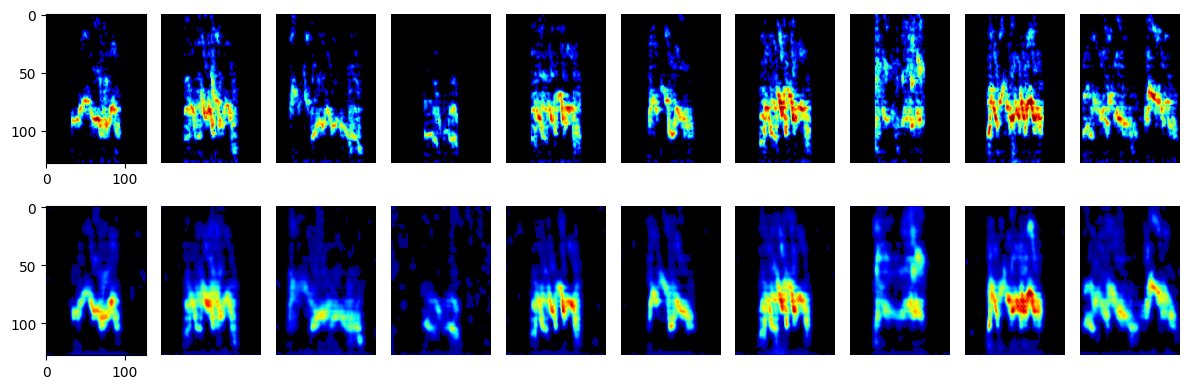

In [12]:
## check recontruction accuracy (optional)
# plot some random samples
fig, ax = plt.subplots(2, 10, figsize=[12,4])
random.seed(1118)
random_i = random.sample(list(range(recon.shape[0])), 10)
with h5py.File(fn_spec, 'r') as file:
    for ii in range(10):
        spec = train_data[random_i[ii],:,:].numpy()
        ax[0][ii].imshow(np.flip(spec, 0), aspect='auto', vmin=0, vmax=1, cmap=custom_cmap)
        spec = recon[random_i[ii],:,:]
        ax[1][ii].imshow(np.flip(spec, 0), aspect='auto', vmin=0, vmax=1, cmap=custom_cmap)
        if ii>0:
            ax[0][ii].axis('off')
            ax[1][ii].axis('off')
plt.tight_layout()
# save fig
fn_fig = os.path.join(fd_save, 'reconstructed_spectrogram.pdf')
fig.savefig(fn_fig)


## 3. Run UMAP/HDBSCAN

In [7]:
fn_info = os.path.join(fd_data, bd, 'Spectrogram2', sylStr, f'{bd}.{sylStr}.{rn}.info.csv')
info = pd.read_csv(fn_info, index_col=0)

In [8]:
# read latent features
fn_latentM = os.path.join(fd_save, 'latentM.csv')
latent_m = np.loadtxt(fn_latentM, delimiter=',')
latent_m.shape

(36359, 32)

In [9]:
# add latent_m to the embedding data frame
embed = info.copy()
for ii in range(latent_m.shape[1]):
    embed[f'vae{ii}'] = latent_m[:,ii]

### UMAP

In [10]:
## run UMAP 
print(param_umap)
umap_model = umap.UMAP(n_neighbors=param_umap['n_neighbors'], n_components=param_umap['n_components'], min_dist=param_umap['min_dist'], 
                                              metric=param_umap['metric'], random_state=1118, verbose=True)
res = umap_model.fit_transform(latent_m)

# add UMAP embedding to the dataframe
for jj in range(res.shape[1]):
    embed[f'umap{jj+1}'] = res[:,jj]

{'n_components': 2, 'n_neighbors': 25, 'min_dist': 0, 'metric': 'cosine'}
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Thu Jul  3 16:19:37 2025 Construct fuzzy simplicial set
Thu Jul  3 16:19:37 2025 Finding Nearest Neighbors
Thu Jul  3 16:19:37 2025 Building RP forest with 15 trees


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Thu Jul  3 16:19:40 2025 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Thu Jul  3 16:19:49 2025 Finished Nearest Neighbor Search
Thu Jul  3 16:19:51 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Thu Jul  3 16:20:05 2025 Finished embedding


In [11]:
# save the UMAP model for later usage
fn_umap = os.path.join(fd_save, f'UMAPmodel_{bd}.p')
pickle.dump(umap_model, open(fn_umap, 'wb'))

Thu Jul  3 16:20:11 2025 Worst tree score: 0.81237108
Thu Jul  3 16:20:11 2025 Mean tree score: 0.81631691
Thu Jul  3 16:20:11 2025 Best tree score: 0.81987953
Thu Jul  3 16:20:13 2025 Forward diversification reduced edges from 908975 to 308731
Thu Jul  3 16:20:14 2025 Reverse diversification reduced edges from 308731 to 308731
Thu Jul  3 16:20:16 2025 Degree pruning reduced edges from 340882 to 340882
Thu Jul  3 16:20:16 2025 Resorting data and graph based on tree order
Thu Jul  3 16:20:16 2025 Building and compiling search function


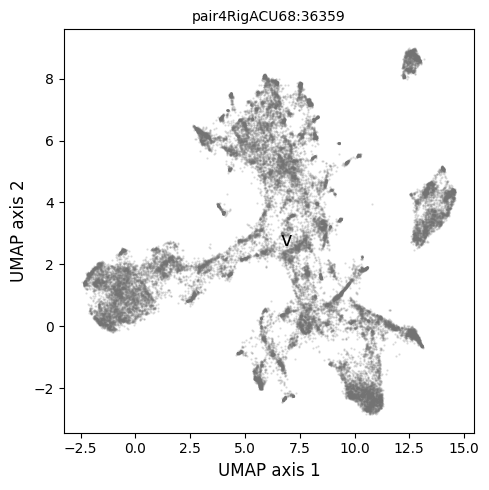

In [12]:
## plot embedding
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[5, 5])
for si, ss in enumerate(syl):
    embed_s = embed[embed['label']==ss]
    ax.scatter(embed_s['umap1'], embed_s['umap2'], s=0.3, alpha=0.25, c='#737373')
    # add syl label
    ax.text(np.mean(embed_s['umap1']), np.mean(embed_s['umap2']), ss, fontsize=14)
ax.set_title(f'{bd}:{embed.shape[0]}', fontsize=10)
ax.set_xlabel('UMAP axis 1', fontsize=12)
ax.set_ylabel('UMAP axis 2', fontsize=12)
plt.tight_layout()
# save fig
fn_fig =os.path.join(fd_save, f'{bd}.UMAPonVAE.embedding.pdf')
fig.savefig(fn_fig)

### HDBSCAN clustering

In [13]:
res.shape[0] * 0.05

1817.95

In [14]:
## HDBSCAN clustering
clusterer = hdbscan.HDBSCAN(min_cluster_size=int(res.shape[0]* param_hdbscan['min_cluster_size_frac']), min_samples=param_hdbscan['min_samples'], 
                            cluster_selection_method=param_hdbscan['select_method'], prediction_data=True)
# clusterer = hdbscan.HDBSCAN(min_cluster_size=1500, min_samples=20, 
#                             cluster_selection_method='leaf')
# clusterer = hdbscan.HDBSCAN(min_cluster_size=200, min_samples=20)
clusterer.fit(res)
embed['hdbscan_cluster'] = clusterer.labels_ + 1    # no clustering is label 0
embed['hdbscan_prob'] = clusterer.probabilities_

# save embedding and clustering 
fn_embed = os.path.join(fd_save, f'{bd}.{rn}.embedding.csv')
embed.to_csv(fn_embed)

# what's the fraction that's not clustered
unc_f = embed[embed['hdbscan_cluster']==0].shape[0] / embed.shape[0]
print(f'The fraction that are not clustered: {unc_f:.4f}')
num_c = max(embed['hdbscan_cluster'])
print(f'Total number of clusters: {num_c}')

The fraction that are not clustered: 0.2174
Total number of clusters: 6


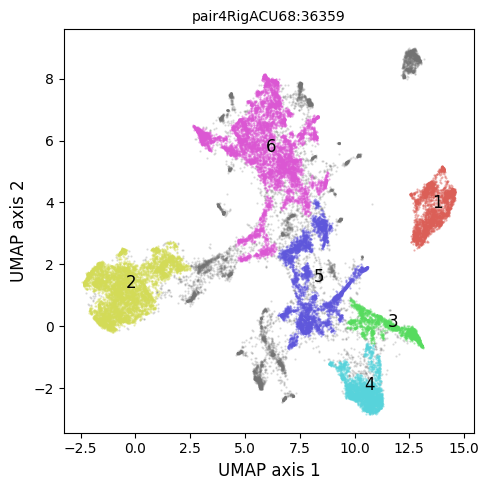

In [15]:
# color calls according to hdbscan labels
col_long = sns.color_palette('hls', n_colors=max(embed['hdbscan_cluster']))
# plot embedding
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[5, 5])
for hi in range(0, max(embed['hdbscan_cluster'])+1):
    embed_s = embed[embed['hdbscan_cluster']==hi]
    if hi==0:
        ax.scatter(embed_s['umap1'], embed_s['umap2'], s=0.3, alpha=0.25, color='#737373')
    else:
        ax.scatter(embed_s['umap1'], embed_s['umap2'], s=0.3, alpha=0.5, color=col_long[hi-1])
        # add syl label
        ax.text(np.mean(embed_s['umap1']), np.mean(embed_s['umap2']), hi, fontsize=12)
ax.set_title(f'{bd}:{embed.shape[0]}', fontsize=10)
ax.set_xlabel('UMAP axis 1', fontsize=12)
ax.set_ylabel('UMAP axis 2', fontsize=12)
plt.tight_layout()
# save fig
fn_fig = os.path.join(fd_save, f'{bd}.UMAPonVAE.HBBSCAN.pdf')
fig.savefig(fn_fig)

In [16]:
# save HDBSCAN model for future use
fn_cluster = os.path.join(fd_save, f'HDBSCANmodel_{bd}.p')
pickle.dump(clusterer, open(fn_cluster, 'wb'))

In [17]:
# save the color list as well
col_long_np = np.array(col_long)
fn_col = os.path.join(fd_save, 'color.txt')
np.savetxt(fn_col, col_long_np, delimiter=',')

### Quantify clustering quality

In [33]:
## Quantify clustering tendency
# in UMAP space
hpk1 = hopkins2.hopkins_statistic(res, rng=1992)
print(f'Hopkins metric in UMAP: {hpk1:.4f}')
# in VAE space
hpk2 = hopkins2.hopkins_statistic(latent_m, rng=1992)
print(f'Hopkins metric in VAE: {hpk2:.4f}')

## Quantify clustering quality with Silhoutte score
# in UMAP space
sil1 = silhouette_score(res, embed['hdbscan_cluster'], random_state=1118, metric='euclidean')
print(f'HDBSCAN Silhouette score in UMAP: {sil1:.4f}')
# in VAE space
sil2 = silhouette_score(latent_m, embed['hdbscan_cluster'], random_state=1118, metric='euclidean')
print(f'HDBSCAN Silhouette score in VAE: {sil2:.4f}')

# Calinski–Harabasz (CH) Index
cah1 = calinski_harabasz_score(res, embed['hdbscan_cluster'])
print(f'Calinski–Harabasz index in UMAP: {cah1:.4f}')
cah2 = calinski_harabasz_score(latent_m, embed['hdbscan_cluster'])
print(f'Calinski–Harabasz index in VAE: {cah2:.4f}')

# save data to the master data frame
metrics = pd.DataFrame([{'birdID':bd, 'run_name':rn, 'num_cluster':num_c, 'frac_unclustered':unc_f, 'cluster_persist':clusterer.cluster_persistence_, 'hopkins_umap':hpk1, 
                     'hopkins_vae':hpk2, 'silhouette_umap':sil1, 'silhouette_vae':sil2, 'calinski_umap':cah1, 'calinski_vae':cah2, 'param_umap':param_umap, 'param_hdbscan':param_hdbscan}])

Hopkins metric in UMAP: 0.9819
Hopkins metric in VAE: 0.8502
HDBSCAN Silhouette score in UMAP: 0.3709
HDBSCAN Silhouette score in VAE: 0.0047
Calinski–Harabasz index in UMAP: 20164.4889
Calinski–Harabasz index in VAE: 1423.1547


In [34]:
# save the metrics
fn_metric = os.path.join(fd_save, f'{bd}.UMAPonVAE.metrics.csv')
metrics.to_csv(fn_metric)
metrics

,birdID,run_name,num_cluster,frac_unclustered,cluster_persist,hopkins_umap,hopkins_vae,silhouette_umap,silhouette_vae,calinski_umap,calinski_vae,param_umap,param_hdbscan
0,pair4RigACU68,spec_goffinet_nn_256_176,6,0.217415,"[0.5245164224515599, 0.37068731176893394, 0.13...",0.98193,0.850167,0.370939,0.004655,20164.488947,1423.15465,"{'n_components': 2, 'n_neighbors': 25, 'min_di...","{'min_cluster_size_frac': 0.05, 'min_samples':..."


## 4. Simulate the random datasets

In [44]:
# number of trials to simulate
n = 200

In [45]:
# load the real dataset
fn_latentM = os.path.join(fd_save, 'latentM.csv')
latent_m = np.loadtxt(fn_latentM, delimiter=',')
latent_m.shape

(36359, 32)

In [46]:
 # estimated mean and variance
mu = latent_m.mean(axis=0)                        # empirical mean  (shape: 32,)
Sigma  = np.cov(latent_m, rowvar=False, ddof=1)

In [ ]:
# save metrics in a master dataframe
metrics = pd.DataFrame()
np.random.seed(1118)
for i in range(n):
# for i in range(2):
    rng = np.random.default_rng()  
    latent_rd = rng.multivariate_normal(mean=mu, cov=Sigma, size=latent_m.shape[0], method='cholesky')
    
    # then run UMAP and HDBSCAN exactly as for real datasets
    ## run UMAP 
    umap_model = umap.UMAP(n_neighbors=param_umap['n_neighbors'], n_components=param_umap['n_components'], min_dist=param_umap['min_dist'], 
                                                  metric=param_umap['metric'], random_state=1118, verbose=True)
    res = umap_model.fit_transform(latent_rd)

    ## HDBSCAN clustering
    clusterer = hdbscan.HDBSCAN(min_cluster_size=int(res.shape[0]* param_hdbscan['min_cluster_size_frac']), min_samples=param_hdbscan['min_samples'], 
                                cluster_selection_method=param_hdbscan['select_method'])
    # clusterer = hdbscan.HDBSCAN(min_cluster_size=800, min_samples=20, 
    #                             cluster_selection_method='leaf')
    # clusterer = hdbscan.HDBSCAN(min_cluster_size=200, min_samples=20)
    clusterer.fit(res)
    
    labs = clusterer.labels_; 
    # what's the fraction that's not clustered
    unc_f = labs[labs==-1].shape[0] / labs.shape[0]
    print(f'The fraction that are not clustered: {unc_f:.4f}')
    num_c = max(labs+1)
    print(f'Total number of clusters: {num_c}')
    
    if num_c==0:
        continue

    ## Quantify clustering tendency
    # in UMAP space
    hpk1 = hopkins2.hopkins_statistic(res, rng=1992)
    print(f'Hopkins metric in UMAP: {hpk1:.4f}')
    # in VAE space
    hpk2 = hopkins2.hopkins_statistic(latent_m, rng=1992)
    print(f'Hopkins metric in VAE: {hpk2:.4f}')

    ## Quantify clustering quality with Silhoutte score
    # in UMAP space
    sil1 = silhouette_score(res, labs, random_state=1118, metric='euclidean')
    print(f'HDBSCAN Silhouette score in UMAP: {sil1:.4f}')
    # in VAE space
    sil2 = silhouette_score(latent_m, labs, random_state=1118, metric='euclidean')
    print(f'HDBSCAN Silhouette score in VAE: {sil2:.4f}')

    # Calinski–Harabasz (CH) Index
    cah1 = calinski_harabasz_score(res, labs)
    print(f'Calinski–Harabasz index in UMAP: {cah1:.4f}')
    cah2 = calinski_harabasz_score(latent_m, labs)
    print(f'Calinski–Harabasz index in VAE: {cah2:.4f}')

    # save data to the master data frame
    row = pd.DataFrame([{'birdID':bd, 'run_id':i, 'num_cluster':num_c, 'frac_unclustered':unc_f, 'cluster_persist':clusterer.cluster_persistence_, 'hopkins_umap':hpk1, 
                         'hopkins_vae':hpk2, 'silhouette_umap':sil1, 'silhouette_vae':sil2, 'calinski_umap':cah1, 'calinski_vae':cah2, 'param_umap':param_umap, 'param_hdbscan':param_hdbscan}])
    metrics = pd.concat([metrics, row], ignore_index=True)

/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 20:39:49 2025 Construct fuzzy simplicial set
Fri Jun 20 20:39:49 2025 Finding Nearest Neighbors
Fri Jun 20 20:39:49 2025 Building RP forest with 15 trees
Fri Jun 20 20:39:49 2025 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 20:39:51 2025 Finished Nearest Neighbor Search
Fri Jun 20 20:39:51 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 20:40:05 2025 Finished embedding
The fraction that are not clustered: 0.6757
Total number of clusters: 3
Hopkins metric in UMAP: 0.8840
Hopkins metric in VAE: 0.8502
HDBSCAN Silhouette score in UMAP: -0.1047
HDBSCAN Silhouette score in VAE: -0.0036
Calinski–Harabasz index in UMAP: 4034.1671
Calinski–Harabasz index in VAE: 0.8880
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 20:40:36 2025 Construct fuzzy simplicial set
Fri Jun 20 20:40:36 2025 Finding Nearest Neighbors
Fri Jun 20 20:40:36 2025 Building RP forest with 15 trees


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Fri Jun 20 20:40:37 2025 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 20:40:38 2025 Finished Nearest Neighbor Search
Fri Jun 20 20:40:38 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 20:40:53 2025 Finished embedding
The fraction that are not clustered: 0.4776
Total number of clusters: 3
Hopkins metric in UMAP: 0.8841
Hopkins metric in VAE: 0.8502
HDBSCAN Silhouette score in UMAP: 0.0072
HDBSCAN Silhouette score in VAE: -0.0036
Calinski–Harabasz index in UMAP: 4351.1354
Calinski–Harabasz index in VAE: 1.0066
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 20:41:19 2025 Construct fuzzy simplicial set
Fri Jun 20 20:41:19 2025 Finding Nearest Neighbors
Fri Jun 20 20:41:19 2025 Building RP forest with 15 trees
Fri Jun 20 20:41:19 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 20:41:21 2025 Finished Nearest Neighbor Search
Fri Jun 20 20:41:21 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 20:41:35 2025 Finished embedding
The fraction that are not clustered: 0.6209
Total number of clusters: 3
Hopkins metric in UMAP: 0.8834
Hopkins metric in VAE: 0.8502
HDBSCAN Silhouette score in UMAP: -0.1250
HDBSCAN Silhouette score in VAE: -0.0018
Calinski–Harabasz index in UMAP: 2734.9907
Calinski–Harabasz index in VAE: 1.1467
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 20:42:02 2025 Construct fuzzy simplicial set
Fri Jun 20 20:42:02 2025 Finding Nearest Neighbors
Fri Jun 20 20:42:02 2025 Building RP forest with 15 trees
Fri Jun 20 20:42:02 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 20:42:04 2025 Finished Nearest Neighbor Search
Fri Jun 20 20:42:04 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 20:42:18 2025 Finished embedding
The fraction that are not clustered: 0.5730
Total number of clusters: 4
Hopkins metric in UMAP: 0.8906
Hopkins metric in VAE: 0.8502
HDBSCAN Silhouette score in UMAP: -0.1175
HDBSCAN Silhouette score in VAE: -0.0043
Calinski–Harabasz index in UMAP: 3448.8262
Calinski–Harabasz index in VAE: 0.9333
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 20:42:44 2025 Construct fuzzy simplicial set
Fri Jun 20 20:42:44 2025 Finding Nearest Neighbors
Fri Jun 20 20:42:44 2025 Building RP forest with 15 trees
Fri Jun 20 20:42:45 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 20:42:46 2025 Finished Nearest Neighbor Search
Fri Jun 20 20:42:46 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 20:43:01 2025 Finished embedding
The fraction that are not clustered: 0.5717
Total number of clusters: 4
Hopkins metric in UMAP: 0.8941
Hopkins metric in VAE: 0.8502
HDBSCAN Silhouette score in UMAP: -0.1337
HDBSCAN Silhouette score in VAE: -0.0045
Calinski–Harabasz index in UMAP: 3109.7222
Calinski–Harabasz index in VAE: 0.7884
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 20:43:27 2025 Construct fuzzy simplicial set
Fri Jun 20 20:43:27 2025 Finding Nearest Neighbors
Fri Jun 20 20:43:27 2025 Building RP forest with 15 trees
Fri Jun 20 20:43:27 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 20:43:29 2025 Finished Nearest Neighbor Search
Fri Jun 20 20:43:29 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 20:43:43 2025 Finished embedding
The fraction that are not clustered: 0.6382
Total number of clusters: 4
Hopkins metric in UMAP: 0.8942
Hopkins metric in VAE: 0.8502
HDBSCAN Silhouette score in UMAP: -0.1368
HDBSCAN Silhouette score in VAE: -0.0035
Calinski–Harabasz index in UMAP: 3913.0566
Calinski–Harabasz index in VAE: 0.8364
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 20:44:10 2025 Construct fuzzy simplicial set
Fri Jun 20 20:44:10 2025 Finding Nearest Neighbors
Fri Jun 20 20:44:10 2025 Building RP forest with 15 trees
Fri Jun 20 20:44:10 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 20:44:11 2025 Finished Nearest Neighbor Search
Fri Jun 20 20:44:11 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 20:44:25 2025 Finished embedding
The fraction that are not clustered: 0.7570
Total number of clusters: 3
Hopkins metric in UMAP: 0.8984
Hopkins metric in VAE: 0.8502
HDBSCAN Silhouette score in UMAP: -0.1741
HDBSCAN Silhouette score in VAE: -0.0027
Calinski–Harabasz index in UMAP: 2350.2241
Calinski–Harabasz index in VAE: 0.9235
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 20:44:53 2025 Construct fuzzy simplicial set
Fri Jun 20 20:44:53 2025 Finding Nearest Neighbors
Fri Jun 20 20:44:53 2025 Building RP forest with 15 trees
Fri Jun 20 20:44:53 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 20:44:55 2025 Finished Nearest Neighbor Search
Fri Jun 20 20:44:55 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 20:45:09 2025 Finished embedding
The fraction that are not clustered: 0.7200
Total number of clusters: 4
Hopkins metric in UMAP: 0.8970
Hopkins metric in VAE: 0.8502
HDBSCAN Silhouette score in UMAP: -0.2253
HDBSCAN Silhouette score in VAE: -0.0065
Calinski–Harabasz index in UMAP: 2024.2190
Calinski–Harabasz index in VAE: 1.2098
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 20:45:37 2025 Construct fuzzy simplicial set
Fri Jun 20 20:45:37 2025 Finding Nearest Neighbors
Fri Jun 20 20:45:37 2025 Building RP forest with 15 trees
Fri Jun 20 20:45:37 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 20:45:38 2025 Finished Nearest Neighbor Search
Fri Jun 20 20:45:39 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 20:45:53 2025 Finished embedding
The fraction that are not clustered: 0.7061
Total number of clusters: 3
Hopkins metric in UMAP: 0.8908
Hopkins metric in VAE: 0.8502
HDBSCAN Silhouette score in UMAP: -0.1574
HDBSCAN Silhouette score in VAE: -0.0028
Calinski–Harabasz index in UMAP: 2319.7663
Calinski–Harabasz index in VAE: 1.2348
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 20:46:20 2025 Construct fuzzy simplicial set
Fri Jun 20 20:46:20 2025 Finding Nearest Neighbors
Fri Jun 20 20:46:20 2025 Building RP forest with 15 trees
Fri Jun 20 20:46:20 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 20:46:22 2025 Finished Nearest Neighbor Search
Fri Jun 20 20:46:22 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 20:46:36 2025 Finished embedding
The fraction that are not clustered: 0.5930
Total number of clusters: 4
Hopkins metric in UMAP: 0.8901
Hopkins metric in VAE: 0.8502
HDBSCAN Silhouette score in UMAP: -0.1197
HDBSCAN Silhouette score in VAE: -0.0040
Calinski–Harabasz index in UMAP: 3665.9401
Calinski–Harabasz index in VAE: 0.8899
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 20:47:03 2025 Construct fuzzy simplicial set
Fri Jun 20 20:47:03 2025 Finding Nearest Neighbors
Fri Jun 20 20:47:03 2025 Building RP forest with 15 trees
Fri Jun 20 20:47:03 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 20:47:05 2025 Finished Nearest Neighbor Search
Fri Jun 20 20:47:05 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 20:47:19 2025 Finished embedding
The fraction that are not clustered: 0.7110
Total number of clusters: 2
Hopkins metric in UMAP: 0.8776
Hopkins metric in VAE: 0.8502
HDBSCAN Silhouette score in UMAP: -0.0960
HDBSCAN Silhouette score in VAE: -0.0012
Calinski–Harabasz index in UMAP: 2179.3011
Calinski–Harabasz index in VAE: 0.8859
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 20:47:46 2025 Construct fuzzy simplicial set
Fri Jun 20 20:47:46 2025 Finding Nearest Neighbors
Fri Jun 20 20:47:46 2025 Building RP forest with 15 trees
Fri Jun 20 20:47:47 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 20:47:48 2025 Finished Nearest Neighbor Search
Fri Jun 20 20:47:48 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 20:48:03 2025 Finished embedding
The fraction that are not clustered: 0.7357
Total number of clusters: 4
Hopkins metric in UMAP: 0.8916
Hopkins metric in VAE: 0.8502
HDBSCAN Silhouette score in UMAP: -0.2115
HDBSCAN Silhouette score in VAE: -0.0046
Calinski–Harabasz index in UMAP: 2628.5775
Calinski–Harabasz index in VAE: 1.1659
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 20:48:30 2025 Construct fuzzy simplicial set
Fri Jun 20 20:48:30 2025 Finding Nearest Neighbors
Fri Jun 20 20:48:30 2025 Building RP forest with 15 trees
Fri Jun 20 20:48:30 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 20:48:32 2025 Finished Nearest Neighbor Search
Fri Jun 20 20:48:32 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 20:48:46 2025 Finished embedding
The fraction that are not clustered: 0.5890
Total number of clusters: 2
Hopkins metric in UMAP: 0.9047
Hopkins metric in VAE: 0.8502
HDBSCAN Silhouette score in UMAP: -0.0260
HDBSCAN Silhouette score in VAE: -0.0006
Calinski–Harabasz index in UMAP: 3524.2449
Calinski–Harabasz index in VAE: 0.4956
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 20:49:13 2025 Construct fuzzy simplicial set
Fri Jun 20 20:49:13 2025 Finding Nearest Neighbors
Fri Jun 20 20:49:13 2025 Building RP forest with 15 trees
Fri Jun 20 20:49:13 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 20:49:15 2025 Finished Nearest Neighbor Search
Fri Jun 20 20:49:15 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 20:49:29 2025 Finished embedding
The fraction that are not clustered: 0.6617
Total number of clusters: 4
Hopkins metric in UMAP: 0.8739
Hopkins metric in VAE: 0.8502
HDBSCAN Silhouette score in UMAP: -0.1983
HDBSCAN Silhouette score in VAE: -0.0048
Calinski–Harabasz index in UMAP: 2187.0213
Calinski–Harabasz index in VAE: 0.8585
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 20:49:56 2025 Construct fuzzy simplicial set
Fri Jun 20 20:49:56 2025 Finding Nearest Neighbors
Fri Jun 20 20:49:56 2025 Building RP forest with 15 trees
Fri Jun 20 20:49:56 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 20:49:58 2025 Finished Nearest Neighbor Search
Fri Jun 20 20:49:58 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 20:50:12 2025 Finished embedding
The fraction that are not clustered: 0.6176
Total number of clusters: 4
Hopkins metric in UMAP: 0.8904
Hopkins metric in VAE: 0.8502
HDBSCAN Silhouette score in UMAP: -0.1591
HDBSCAN Silhouette score in VAE: -0.0034
Calinski–Harabasz index in UMAP: 2807.6925
Calinski–Harabasz index in VAE: 1.3832
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 20:50:39 2025 Construct fuzzy simplicial set
Fri Jun 20 20:50:39 2025 Finding Nearest Neighbors
Fri Jun 20 20:50:39 2025 Building RP forest with 15 trees
Fri Jun 20 20:50:39 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 20:50:41 2025 Finished Nearest Neighbor Search
Fri Jun 20 20:50:41 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 20:50:55 2025 Finished embedding
The fraction that are not clustered: 0.6878
Total number of clusters: 4
Hopkins metric in UMAP: 0.8999
Hopkins metric in VAE: 0.8502
HDBSCAN Silhouette score in UMAP: -0.1919
HDBSCAN Silhouette score in VAE: -0.0023
Calinski–Harabasz index in UMAP: 2664.7137
Calinski–Harabasz index in VAE: 1.1364
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 20:51:22 2025 Construct fuzzy simplicial set
Fri Jun 20 20:51:22 2025 Finding Nearest Neighbors
Fri Jun 20 20:51:22 2025 Building RP forest with 15 trees
Fri Jun 20 20:51:22 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 20:51:24 2025 Finished Nearest Neighbor Search
Fri Jun 20 20:51:24 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 20:51:38 2025 Finished embedding
The fraction that are not clustered: 0.6053
Total number of clusters: 4
Hopkins metric in UMAP: 0.8820
Hopkins metric in VAE: 0.8502
HDBSCAN Silhouette score in UMAP: -0.1711
HDBSCAN Silhouette score in VAE: -0.0037
Calinski–Harabasz index in UMAP: 2121.1302
Calinski–Harabasz index in VAE: 0.9558
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 20:52:05 2025 Construct fuzzy simplicial set
Fri Jun 20 20:52:05 2025 Finding Nearest Neighbors
Fri Jun 20 20:52:05 2025 Building RP forest with 15 trees
Fri Jun 20 20:52:05 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 20:52:07 2025 Finished Nearest Neighbor Search
Fri Jun 20 20:52:07 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 20:52:21 2025 Finished embedding
The fraction that are not clustered: 0.6414
Total number of clusters: 4
Hopkins metric in UMAP: 0.8848
Hopkins metric in VAE: 0.8502
HDBSCAN Silhouette score in UMAP: -0.1543
HDBSCAN Silhouette score in VAE: -0.0039
Calinski–Harabasz index in UMAP: 2783.0808
Calinski–Harabasz index in VAE: 0.8227
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 20:52:48 2025 Construct fuzzy simplicial set
Fri Jun 20 20:52:48 2025 Finding Nearest Neighbors
Fri Jun 20 20:52:48 2025 Building RP forest with 15 trees
Fri Jun 20 20:52:48 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 20:52:50 2025 Finished Nearest Neighbor Search
Fri Jun 20 20:52:50 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 20:53:04 2025 Finished embedding
The fraction that are not clustered: 0.6791
Total number of clusters: 3
Hopkins metric in UMAP: 0.8887
Hopkins metric in VAE: 0.8502
HDBSCAN Silhouette score in UMAP: -0.1324
HDBSCAN Silhouette score in VAE: -0.0026
Calinski–Harabasz index in UMAP: 3009.6703
Calinski–Harabasz index in VAE: 1.1216
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 20:53:31 2025 Construct fuzzy simplicial set
Fri Jun 20 20:53:31 2025 Finding Nearest Neighbors
Fri Jun 20 20:53:31 2025 Building RP forest with 15 trees
Fri Jun 20 20:53:32 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 20:53:33 2025 Finished Nearest Neighbor Search
Fri Jun 20 20:53:33 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 20:53:48 2025 Finished embedding
The fraction that are not clustered: 0.5461
Total number of clusters: 3
Hopkins metric in UMAP: 0.8795
Hopkins metric in VAE: 0.8502
HDBSCAN Silhouette score in UMAP: -0.0593
HDBSCAN Silhouette score in VAE: -0.0055
Calinski–Harabasz index in UMAP: 3926.5400
Calinski–Harabasz index in VAE: 1.1545
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 20:54:14 2025 Construct fuzzy simplicial set
Fri Jun 20 20:54:14 2025 Finding Nearest Neighbors
Fri Jun 20 20:54:14 2025 Building RP forest with 15 trees
Fri Jun 20 20:54:14 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 20:54:16 2025 Finished Nearest Neighbor Search
Fri Jun 20 20:54:16 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 20:54:30 2025 Finished embedding
The fraction that are not clustered: 0.6511
Total number of clusters: 5
Hopkins metric in UMAP: 0.8787
Hopkins metric in VAE: 0.8502
HDBSCAN Silhouette score in UMAP: -0.2081
HDBSCAN Silhouette score in VAE: -0.0049
Calinski–Harabasz index in UMAP: 2500.9034
Calinski–Harabasz index in VAE: 1.0203
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 20:54:57 2025 Construct fuzzy simplicial set
Fri Jun 20 20:54:57 2025 Finding Nearest Neighbors
Fri Jun 20 20:54:57 2025 Building RP forest with 15 trees
Fri Jun 20 20:54:57 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 20:54:59 2025 Finished Nearest Neighbor Search
Fri Jun 20 20:54:59 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 20:55:13 2025 Finished embedding
The fraction that are not clustered: 0.7368
Total number of clusters: 4
Hopkins metric in UMAP: 0.8771
Hopkins metric in VAE: 0.8502
HDBSCAN Silhouette score in UMAP: -0.2527
HDBSCAN Silhouette score in VAE: -0.0028
Calinski–Harabasz index in UMAP: 1691.2246
Calinski–Harabasz index in VAE: 1.0678
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 20:55:41 2025 Construct fuzzy simplicial set
Fri Jun 20 20:55:41 2025 Finding Nearest Neighbors
Fri Jun 20 20:55:41 2025 Building RP forest with 15 trees
Fri Jun 20 20:55:41 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 20:55:43 2025 Finished Nearest Neighbor Search
Fri Jun 20 20:55:43 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 20:55:57 2025 Finished embedding
The fraction that are not clustered: 0.6492
Total number of clusters: 4
Hopkins metric in UMAP: 0.8923
Hopkins metric in VAE: 0.8502
HDBSCAN Silhouette score in UMAP: -0.1794
HDBSCAN Silhouette score in VAE: -0.0026
Calinski–Harabasz index in UMAP: 2372.2547
Calinski–Harabasz index in VAE: 0.7628
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 20:56:24 2025 Construct fuzzy simplicial set
Fri Jun 20 20:56:24 2025 Finding Nearest Neighbors
Fri Jun 20 20:56:24 2025 Building RP forest with 15 trees
Fri Jun 20 20:56:24 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 20:56:25 2025 Finished Nearest Neighbor Search
Fri Jun 20 20:56:26 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 20:56:40 2025 Finished embedding
The fraction that are not clustered: 0.5849
Total number of clusters: 2
Hopkins metric in UMAP: 0.8883
Hopkins metric in VAE: 0.8502
HDBSCAN Silhouette score in UMAP: -0.0251
HDBSCAN Silhouette score in VAE: -0.0010
Calinski–Harabasz index in UMAP: 3170.6773
Calinski–Harabasz index in VAE: 1.3363
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 20:57:06 2025 Construct fuzzy simplicial set
Fri Jun 20 20:57:06 2025 Finding Nearest Neighbors
Fri Jun 20 20:57:06 2025 Building RP forest with 15 trees
Fri Jun 20 20:57:06 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 20:57:08 2025 Finished Nearest Neighbor Search
Fri Jun 20 20:57:08 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 20:57:22 2025 Finished embedding
The fraction that are not clustered: 0.5602
Total number of clusters: 4
Hopkins metric in UMAP: 0.8681
Hopkins metric in VAE: 0.8502
HDBSCAN Silhouette score in UMAP: -0.1019
HDBSCAN Silhouette score in VAE: -0.0046
Calinski–Harabasz index in UMAP: 4405.7481
Calinski–Harabasz index in VAE: 1.0451
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 20:57:49 2025 Construct fuzzy simplicial set
Fri Jun 20 20:57:49 2025 Finding Nearest Neighbors
Fri Jun 20 20:57:49 2025 Building RP forest with 15 trees
Fri Jun 20 20:57:49 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 20:57:51 2025 Finished Nearest Neighbor Search
Fri Jun 20 20:57:51 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 20:58:05 2025 Finished embedding
The fraction that are not clustered: 0.6991
Total number of clusters: 3
Hopkins metric in UMAP: 0.8871
Hopkins metric in VAE: 0.8502
HDBSCAN Silhouette score in UMAP: -0.1474
HDBSCAN Silhouette score in VAE: -0.0026
Calinski–Harabasz index in UMAP: 2670.3178
Calinski–Harabasz index in VAE: 1.0842
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 20:58:33 2025 Construct fuzzy simplicial set
Fri Jun 20 20:58:33 2025 Finding Nearest Neighbors
Fri Jun 20 20:58:33 2025 Building RP forest with 15 trees
Fri Jun 20 20:58:33 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 20:58:34 2025 Finished Nearest Neighbor Search
Fri Jun 20 20:58:35 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 20:58:49 2025 Finished embedding
The fraction that are not clustered: 0.6898
Total number of clusters: 5
Hopkins metric in UMAP: 0.8881
Hopkins metric in VAE: 0.8502
HDBSCAN Silhouette score in UMAP: -0.2375
HDBSCAN Silhouette score in VAE: -0.0053
Calinski–Harabasz index in UMAP: 2074.6791
Calinski–Harabasz index in VAE: 0.7261
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 20:59:16 2025 Construct fuzzy simplicial set
Fri Jun 20 20:59:16 2025 Finding Nearest Neighbors
Fri Jun 20 20:59:16 2025 Building RP forest with 15 trees
Fri Jun 20 20:59:16 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 20:59:18 2025 Finished Nearest Neighbor Search
Fri Jun 20 20:59:18 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 20:59:32 2025 Finished embedding
The fraction that are not clustered: 0.6886
Total number of clusters: 4
Hopkins metric in UMAP: 0.8910
Hopkins metric in VAE: 0.8502
HDBSCAN Silhouette score in UMAP: -0.2163
HDBSCAN Silhouette score in VAE: -0.0022
Calinski–Harabasz index in UMAP: 1850.4745
Calinski–Harabasz index in VAE: 1.0740
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 20:59:59 2025 Construct fuzzy simplicial set
Fri Jun 20 20:59:59 2025 Finding Nearest Neighbors
Fri Jun 20 20:59:59 2025 Building RP forest with 15 trees
Fri Jun 20 21:00:00 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 21:00:01 2025 Finished Nearest Neighbor Search
Fri Jun 20 21:00:01 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 21:00:16 2025 Finished embedding
The fraction that are not clustered: 0.5562
Total number of clusters: 4
Hopkins metric in UMAP: 0.8857
Hopkins metric in VAE: 0.8502
HDBSCAN Silhouette score in UMAP: -0.0989
HDBSCAN Silhouette score in VAE: -0.0042
Calinski–Harabasz index in UMAP: 3559.0546
Calinski–Harabasz index in VAE: 0.7826
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 21:00:42 2025 Construct fuzzy simplicial set
Fri Jun 20 21:00:42 2025 Finding Nearest Neighbors
Fri Jun 20 21:00:42 2025 Building RP forest with 15 trees
Fri Jun 20 21:00:42 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 21:00:44 2025 Finished Nearest Neighbor Search
Fri Jun 20 21:00:44 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 21:00:58 2025 Finished embedding
The fraction that are not clustered: 0.7679
Total number of clusters: 3
Hopkins metric in UMAP: 0.8905
Hopkins metric in VAE: 0.8502
HDBSCAN Silhouette score in UMAP: -0.1482
HDBSCAN Silhouette score in VAE: -0.0033
Calinski–Harabasz index in UMAP: 3395.9649
Calinski–Harabasz index in VAE: 1.0853
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 21:01:26 2025 Construct fuzzy simplicial set
Fri Jun 20 21:01:26 2025 Finding Nearest Neighbors
Fri Jun 20 21:01:26 2025 Building RP forest with 15 trees
Fri Jun 20 21:01:26 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 21:01:28 2025 Finished Nearest Neighbor Search
Fri Jun 20 21:01:28 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 21:01:42 2025 Finished embedding
The fraction that are not clustered: 0.6763
Total number of clusters: 3
Hopkins metric in UMAP: 0.8892
Hopkins metric in VAE: 0.8502
HDBSCAN Silhouette score in UMAP: -0.1252
HDBSCAN Silhouette score in VAE: -0.0035
Calinski–Harabasz index in UMAP: 3230.2140
Calinski–Harabasz index in VAE: 0.8466
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 21:02:09 2025 Construct fuzzy simplicial set
Fri Jun 20 21:02:09 2025 Finding Nearest Neighbors
Fri Jun 20 21:02:09 2025 Building RP forest with 15 trees
Fri Jun 20 21:02:10 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 21:02:11 2025 Finished Nearest Neighbor Search
Fri Jun 20 21:02:11 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 21:02:25 2025 Finished embedding
The fraction that are not clustered: 0.5253
Total number of clusters: 3
Hopkins metric in UMAP: 0.8763
Hopkins metric in VAE: 0.8502
HDBSCAN Silhouette score in UMAP: -0.0501
HDBSCAN Silhouette score in VAE: -0.0027
Calinski–Harabasz index in UMAP: 3966.6075
Calinski–Harabasz index in VAE: 1.5623
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 21:02:52 2025 Construct fuzzy simplicial set
Fri Jun 20 21:02:52 2025 Finding Nearest Neighbors
Fri Jun 20 21:02:52 2025 Building RP forest with 15 trees
Fri Jun 20 21:02:52 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 21:02:54 2025 Finished Nearest Neighbor Search
Fri Jun 20 21:02:54 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 21:03:08 2025 Finished embedding
The fraction that are not clustered: 0.5371
Total number of clusters: 3
Hopkins metric in UMAP: 0.8882
Hopkins metric in VAE: 0.8502
HDBSCAN Silhouette score in UMAP: -0.0338
HDBSCAN Silhouette score in VAE: -0.0025
Calinski–Harabasz index in UMAP: 4905.4621
Calinski–Harabasz index in VAE: 1.1010
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 21:03:34 2025 Construct fuzzy simplicial set
Fri Jun 20 21:03:34 2025 Finding Nearest Neighbors
Fri Jun 20 21:03:34 2025 Building RP forest with 15 trees
Fri Jun 20 21:03:34 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 21:03:36 2025 Finished Nearest Neighbor Search
Fri Jun 20 21:03:36 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 21:03:51 2025 Finished embedding
The fraction that are not clustered: 0.5359
Total number of clusters: 5
Hopkins metric in UMAP: 0.8742
Hopkins metric in VAE: 0.8502
HDBSCAN Silhouette score in UMAP: -0.0890
HDBSCAN Silhouette score in VAE: -0.0057
Calinski–Harabasz index in UMAP: 4841.2898
Calinski–Harabasz index in VAE: 0.9702
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 21:04:15 2025 Construct fuzzy simplicial set
Fri Jun 20 21:04:15 2025 Finding Nearest Neighbors
Fri Jun 20 21:04:15 2025 Building RP forest with 15 trees
Fri Jun 20 21:04:15 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 21:04:16 2025 Finished Nearest Neighbor Search
Fri Jun 20 21:04:17 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 21:04:31 2025 Finished embedding
The fraction that are not clustered: 0.6129
Total number of clusters: 3
Hopkins metric in UMAP: 0.8783
Hopkins metric in VAE: 0.8502
HDBSCAN Silhouette score in UMAP: -0.1198
HDBSCAN Silhouette score in VAE: -0.0026
Calinski–Harabasz index in UMAP: 3069.0538
Calinski–Harabasz index in VAE: 1.0182
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 21:04:55 2025 Construct fuzzy simplicial set
Fri Jun 20 21:04:55 2025 Finding Nearest Neighbors
Fri Jun 20 21:04:55 2025 Building RP forest with 15 trees


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Fri Jun 20 21:04:55 2025 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 21:04:57 2025 Finished Nearest Neighbor Search
Fri Jun 20 21:04:57 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 21:05:11 2025 Finished embedding
The fraction that are not clustered: 0.5475
Total number of clusters: 2
Hopkins metric in UMAP: 0.9038
Hopkins metric in VAE: 0.8502
HDBSCAN Silhouette score in UMAP: -0.0233
HDBSCAN Silhouette score in VAE: -0.0014
Calinski–Harabasz index in UMAP: 2947.7243
Calinski–Harabasz index in VAE: 1.6851
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 21:05:35 2025 Construct fuzzy simplicial set
Fri Jun 20 21:05:35 2025 Finding Nearest Neighbors
Fri Jun 20 21:05:35 2025 Building RP forest with 15 trees
Fri Jun 20 21:05:35 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 21:05:37 2025 Finished Nearest Neighbor Search
Fri Jun 20 21:05:37 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 21:05:51 2025 Finished embedding
The fraction that are not clustered: 0.7631
Total number of clusters: 3
Hopkins metric in UMAP: 0.9025
Hopkins metric in VAE: 0.8502
HDBSCAN Silhouette score in UMAP: -0.2094
HDBSCAN Silhouette score in VAE: -0.0025
Calinski–Harabasz index in UMAP: 1313.0595
Calinski–Harabasz index in VAE: 0.6294
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 21:06:17 2025 Construct fuzzy simplicial set
Fri Jun 20 21:06:17 2025 Finding Nearest Neighbors
Fri Jun 20 21:06:17 2025 Building RP forest with 15 trees
Fri Jun 20 21:06:17 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 21:06:18 2025 Finished Nearest Neighbor Search
Fri Jun 20 21:06:19 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 21:06:33 2025 Finished embedding
The fraction that are not clustered: 0.5605
Total number of clusters: 4
Hopkins metric in UMAP: 0.8680
Hopkins metric in VAE: 0.8502
HDBSCAN Silhouette score in UMAP: -0.0967
HDBSCAN Silhouette score in VAE: -0.0018
Calinski–Harabasz index in UMAP: 3826.7568
Calinski–Harabasz index in VAE: 0.9194
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 21:06:57 2025 Construct fuzzy simplicial set
Fri Jun 20 21:06:57 2025 Finding Nearest Neighbors
Fri Jun 20 21:06:57 2025 Building RP forest with 15 trees
Fri Jun 20 21:06:57 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 21:06:59 2025 Finished Nearest Neighbor Search
Fri Jun 20 21:06:59 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 21:07:13 2025 Finished embedding
The fraction that are not clustered: 0.6273
Total number of clusters: 4
Hopkins metric in UMAP: 0.8783
Hopkins metric in VAE: 0.8502
HDBSCAN Silhouette score in UMAP: -0.1557
HDBSCAN Silhouette score in VAE: -0.0051
Calinski–Harabasz index in UMAP: 3028.9121
Calinski–Harabasz index in VAE: 1.0269
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 21:07:37 2025 Construct fuzzy simplicial set
Fri Jun 20 21:07:37 2025 Finding Nearest Neighbors
Fri Jun 20 21:07:37 2025 Building RP forest with 15 trees
Fri Jun 20 21:07:37 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 21:07:39 2025 Finished Nearest Neighbor Search
Fri Jun 20 21:07:39 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 21:07:53 2025 Finished embedding
The fraction that are not clustered: 0.7227
Total number of clusters: 3
Hopkins metric in UMAP: 0.8730
Hopkins metric in VAE: 0.8502
HDBSCAN Silhouette score in UMAP: -0.1465
HDBSCAN Silhouette score in VAE: -0.0029
Calinski–Harabasz index in UMAP: 3338.5524
Calinski–Harabasz index in VAE: 1.1758
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 21:08:19 2025 Construct fuzzy simplicial set
Fri Jun 20 21:08:19 2025 Finding Nearest Neighbors
Fri Jun 20 21:08:19 2025 Building RP forest with 15 trees
Fri Jun 20 21:08:19 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 21:08:21 2025 Finished Nearest Neighbor Search
Fri Jun 20 21:08:21 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 21:08:35 2025 Finished embedding
The fraction that are not clustered: 0.7190
Total number of clusters: 3
Hopkins metric in UMAP: 0.8809
Hopkins metric in VAE: 0.8502
HDBSCAN Silhouette score in UMAP: -0.1731
HDBSCAN Silhouette score in VAE: -0.0001
Calinski–Harabasz index in UMAP: 1994.7918
Calinski–Harabasz index in VAE: 0.5387
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 21:09:03 2025 Construct fuzzy simplicial set
Fri Jun 20 21:09:03 2025 Finding Nearest Neighbors
Fri Jun 20 21:09:03 2025 Building RP forest with 15 trees
Fri Jun 20 21:09:03 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 21:09:05 2025 Finished Nearest Neighbor Search
Fri Jun 20 21:09:05 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 21:09:19 2025 Finished embedding
The fraction that are not clustered: 0.6311
Total number of clusters: 3
Hopkins metric in UMAP: 0.8753
Hopkins metric in VAE: 0.8502
HDBSCAN Silhouette score in UMAP: -0.0407
HDBSCAN Silhouette score in VAE: 0.0010
Calinski–Harabasz index in UMAP: 4955.7128
Calinski–Harabasz index in VAE: 1.1298
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 21:09:42 2025 Construct fuzzy simplicial set
Fri Jun 20 21:09:42 2025 Finding Nearest Neighbors
Fri Jun 20 21:09:42 2025 Building RP forest with 15 trees
Fri Jun 20 21:09:43 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 21:09:44 2025 Finished Nearest Neighbor Search
Fri Jun 20 21:09:44 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 21:10:00 2025 Finished embedding
The fraction that are not clustered: 0.6807
Total number of clusters: 4
Hopkins metric in UMAP: 0.8772
Hopkins metric in VAE: 0.8502
HDBSCAN Silhouette score in UMAP: -0.1586
HDBSCAN Silhouette score in VAE: -0.0031
Calinski–Harabasz index in UMAP: 2763.3022
Calinski–Harabasz index in VAE: 1.2477
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 21:10:25 2025 Construct fuzzy simplicial set
Fri Jun 20 21:10:25 2025 Finding Nearest Neighbors
Fri Jun 20 21:10:25 2025 Building RP forest with 15 trees
Fri Jun 20 21:10:26 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 21:10:27 2025 Finished Nearest Neighbor Search
Fri Jun 20 21:10:27 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 21:10:41 2025 Finished embedding
The fraction that are not clustered: 0.6840
Total number of clusters: 4
Hopkins metric in UMAP: 0.8825
Hopkins metric in VAE: 0.8502
HDBSCAN Silhouette score in UMAP: -0.1751
HDBSCAN Silhouette score in VAE: -0.0033
Calinski–Harabasz index in UMAP: 2603.4319
Calinski–Harabasz index in VAE: 1.0064
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 21:11:05 2025 Construct fuzzy simplicial set
Fri Jun 20 21:11:05 2025 Finding Nearest Neighbors
Fri Jun 20 21:11:05 2025 Building RP forest with 15 trees
Fri Jun 20 21:11:05 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 21:11:07 2025 Finished Nearest Neighbor Search
Fri Jun 20 21:11:07 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 21:11:23 2025 Finished embedding
The fraction that are not clustered: 0.4847
Total number of clusters: 2
Hopkins metric in UMAP: 0.8781
Hopkins metric in VAE: 0.8502
HDBSCAN Silhouette score in UMAP: -0.0038
HDBSCAN Silhouette score in VAE: -0.0011
Calinski–Harabasz index in UMAP: 3589.1068
Calinski–Harabasz index in VAE: 1.0279
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 21:11:48 2025 Construct fuzzy simplicial set
Fri Jun 20 21:11:48 2025 Finding Nearest Neighbors
Fri Jun 20 21:11:48 2025 Building RP forest with 15 trees
Fri Jun 20 21:11:48 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 21:11:50 2025 Finished Nearest Neighbor Search
Fri Jun 20 21:11:50 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 21:12:06 2025 Finished embedding
The fraction that are not clustered: 0.5789
Total number of clusters: 3
Hopkins metric in UMAP: 0.8771
Hopkins metric in VAE: 0.8502
HDBSCAN Silhouette score in UMAP: -0.0855
HDBSCAN Silhouette score in VAE: -0.0025
Calinski–Harabasz index in UMAP: 3099.6535
Calinski–Harabasz index in VAE: 0.9652
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 21:12:32 2025 Construct fuzzy simplicial set
Fri Jun 20 21:12:32 2025 Finding Nearest Neighbors
Fri Jun 20 21:12:32 2025 Building RP forest with 15 trees


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Fri Jun 20 21:12:32 2025 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 21:12:34 2025 Finished Nearest Neighbor Search
Fri Jun 20 21:12:34 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 21:12:49 2025 Finished embedding
The fraction that are not clustered: 0.5915
Total number of clusters: 3
Hopkins metric in UMAP: 0.8788
Hopkins metric in VAE: 0.8502
HDBSCAN Silhouette score in UMAP: -0.0810
HDBSCAN Silhouette score in VAE: -0.0021
Calinski–Harabasz index in UMAP: 3348.6771
Calinski–Harabasz index in VAE: 1.1122
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 21:13:15 2025 Construct fuzzy simplicial set
Fri Jun 20 21:13:15 2025 Finding Nearest Neighbors
Fri Jun 20 21:13:15 2025 Building RP forest with 15 trees
Fri Jun 20 21:13:15 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 21:13:17 2025 Finished Nearest Neighbor Search
Fri Jun 20 21:13:17 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 21:13:32 2025 Finished embedding
The fraction that are not clustered: 0.7686
Total number of clusters: 3
Hopkins metric in UMAP: 0.8939
Hopkins metric in VAE: 0.8502
HDBSCAN Silhouette score in UMAP: -0.1965
HDBSCAN Silhouette score in VAE: -0.0051
Calinski–Harabasz index in UMAP: 2469.3272
Calinski–Harabasz index in VAE: 1.1797
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 21:14:00 2025 Construct fuzzy simplicial set
Fri Jun 20 21:14:00 2025 Finding Nearest Neighbors
Fri Jun 20 21:14:00 2025 Building RP forest with 15 trees
Fri Jun 20 21:14:00 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 21:14:01 2025 Finished Nearest Neighbor Search
Fri Jun 20 21:14:02 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 21:14:17 2025 Finished embedding
The fraction that are not clustered: 0.7076
Total number of clusters: 4
Hopkins metric in UMAP: 0.9002
Hopkins metric in VAE: 0.8502
HDBSCAN Silhouette score in UMAP: -0.2071
HDBSCAN Silhouette score in VAE: -0.0031
Calinski–Harabasz index in UMAP: 2359.5522
Calinski–Harabasz index in VAE: 1.2132
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 21:14:43 2025 Construct fuzzy simplicial set
Fri Jun 20 21:14:43 2025 Finding Nearest Neighbors
Fri Jun 20 21:14:43 2025 Building RP forest with 15 trees


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Fri Jun 20 21:14:44 2025 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 21:14:46 2025 Finished Nearest Neighbor Search
Fri Jun 20 21:14:46 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 21:15:01 2025 Finished embedding
The fraction that are not clustered: 0.6195
Total number of clusters: 3
Hopkins metric in UMAP: 0.9060
Hopkins metric in VAE: 0.8502
HDBSCAN Silhouette score in UMAP: -0.1373
HDBSCAN Silhouette score in VAE: -0.0018
Calinski–Harabasz index in UMAP: 2633.2991
Calinski–Harabasz index in VAE: 0.7429
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 21:15:28 2025 Construct fuzzy simplicial set
Fri Jun 20 21:15:28 2025 Finding Nearest Neighbors
Fri Jun 20 21:15:28 2025 Building RP forest with 15 trees
Fri Jun 20 21:15:28 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 21:15:30 2025 Finished Nearest Neighbor Search
Fri Jun 20 21:15:30 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 21:15:45 2025 Finished embedding
The fraction that are not clustered: 0.6039
Total number of clusters: 4
Hopkins metric in UMAP: 0.8746
Hopkins metric in VAE: 0.8502
HDBSCAN Silhouette score in UMAP: -0.1315
HDBSCAN Silhouette score in VAE: -0.0060
Calinski–Harabasz index in UMAP: 3530.0134
Calinski–Harabasz index in VAE: 0.6676
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 21:16:12 2025 Construct fuzzy simplicial set
Fri Jun 20 21:16:12 2025 Finding Nearest Neighbors
Fri Jun 20 21:16:12 2025 Building RP forest with 15 trees
Fri Jun 20 21:16:12 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 21:16:14 2025 Finished Nearest Neighbor Search
Fri Jun 20 21:16:14 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 21:16:29 2025 Finished embedding
The fraction that are not clustered: 0.6837
Total number of clusters: 2
Hopkins metric in UMAP: 0.8801
Hopkins metric in VAE: 0.8502
HDBSCAN Silhouette score in UMAP: -0.1023
HDBSCAN Silhouette score in VAE: -0.0007
Calinski–Harabasz index in UMAP: 1742.2725
Calinski–Harabasz index in VAE: 0.8242
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 21:16:56 2025 Construct fuzzy simplicial set
Fri Jun 20 21:16:56 2025 Finding Nearest Neighbors
Fri Jun 20 21:16:56 2025 Building RP forest with 15 trees
Fri Jun 20 21:16:56 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 21:16:58 2025 Finished Nearest Neighbor Search
Fri Jun 20 21:16:58 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 21:17:13 2025 Finished embedding
The fraction that are not clustered: 0.6179
Total number of clusters: 3
Hopkins metric in UMAP: 0.8880
Hopkins metric in VAE: 0.8502
HDBSCAN Silhouette score in UMAP: -0.0959
HDBSCAN Silhouette score in VAE: -0.0040
Calinski–Harabasz index in UMAP: 3438.0611
Calinski–Harabasz index in VAE: 1.1252
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 21:17:39 2025 Construct fuzzy simplicial set
Fri Jun 20 21:17:39 2025 Finding Nearest Neighbors
Fri Jun 20 21:17:39 2025 Building RP forest with 15 trees
Fri Jun 20 21:17:39 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 21:17:41 2025 Finished Nearest Neighbor Search
Fri Jun 20 21:17:41 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 21:17:57 2025 Finished embedding
The fraction that are not clustered: 0.4570
Total number of clusters: 2
Hopkins metric in UMAP: 0.8981
Hopkins metric in VAE: 0.8502
HDBSCAN Silhouette score in UMAP: 0.0196
HDBSCAN Silhouette score in VAE: -0.0009
Calinski–Harabasz index in UMAP: 4442.4889
Calinski–Harabasz index in VAE: 1.0457
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 21:18:22 2025 Construct fuzzy simplicial set
Fri Jun 20 21:18:22 2025 Finding Nearest Neighbors
Fri Jun 20 21:18:22 2025 Building RP forest with 15 trees
Fri Jun 20 21:18:22 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 21:18:24 2025 Finished Nearest Neighbor Search
Fri Jun 20 21:18:24 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 21:18:41 2025 Finished embedding
The fraction that are not clustered: 0.5013
Total number of clusters: 2
Hopkins metric in UMAP: 0.8893
Hopkins metric in VAE: 0.8502
HDBSCAN Silhouette score in UMAP: 0.0112
HDBSCAN Silhouette score in VAE: -0.0009
Calinski–Harabasz index in UMAP: 4360.2505
Calinski–Harabasz index in VAE: 0.8914
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 21:19:06 2025 Construct fuzzy simplicial set
Fri Jun 20 21:19:06 2025 Finding Nearest Neighbors
Fri Jun 20 21:19:06 2025 Building RP forest with 15 trees
Fri Jun 20 21:19:06 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 21:19:08 2025 Finished Nearest Neighbor Search
Fri Jun 20 21:19:08 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 21:19:23 2025 Finished embedding
The fraction that are not clustered: 0.5580
Total number of clusters: 4
Hopkins metric in UMAP: 0.8885
Hopkins metric in VAE: 0.8502
HDBSCAN Silhouette score in UMAP: -0.1244
HDBSCAN Silhouette score in VAE: -0.0084
Calinski–Harabasz index in UMAP: 3519.1970
Calinski–Harabasz index in VAE: 0.7848
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 21:19:49 2025 Construct fuzzy simplicial set
Fri Jun 20 21:19:49 2025 Finding Nearest Neighbors
Fri Jun 20 21:19:49 2025 Building RP forest with 15 trees


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Fri Jun 20 21:19:49 2025 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 21:19:51 2025 Finished Nearest Neighbor Search
Fri Jun 20 21:19:51 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 21:20:06 2025 Finished embedding
The fraction that are not clustered: 0.6650
Total number of clusters: 2
Hopkins metric in UMAP: 0.8903
Hopkins metric in VAE: 0.8502
HDBSCAN Silhouette score in UMAP: -0.0788
HDBSCAN Silhouette score in VAE: -0.0023
Calinski–Harabasz index in UMAP: 2799.2999
Calinski–Harabasz index in VAE: 1.2695
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 21:20:33 2025 Construct fuzzy simplicial set
Fri Jun 20 21:20:33 2025 Finding Nearest Neighbors
Fri Jun 20 21:20:33 2025 Building RP forest with 15 trees


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Fri Jun 20 21:20:33 2025 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 21:20:35 2025 Finished Nearest Neighbor Search
Fri Jun 20 21:20:35 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 21:20:50 2025 Finished embedding
The fraction that are not clustered: 0.6440
Total number of clusters: 4
Hopkins metric in UMAP: 0.8851
Hopkins metric in VAE: 0.8502
HDBSCAN Silhouette score in UMAP: -0.1602
HDBSCAN Silhouette score in VAE: -0.0034
Calinski–Harabasz index in UMAP: 2823.5579
Calinski–Harabasz index in VAE: 0.7287
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 21:21:18 2025 Construct fuzzy simplicial set
Fri Jun 20 21:21:18 2025 Finding Nearest Neighbors
Fri Jun 20 21:21:18 2025 Building RP forest with 15 trees


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Fri Jun 20 21:21:18 2025 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 21:21:19 2025 Finished Nearest Neighbor Search
Fri Jun 20 21:21:20 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 21:21:35 2025 Finished embedding
The fraction that are not clustered: 0.6810
Total number of clusters: 3
Hopkins metric in UMAP: 0.8912
Hopkins metric in VAE: 0.8502
HDBSCAN Silhouette score in UMAP: -0.1627
HDBSCAN Silhouette score in VAE: -0.0042
Calinski–Harabasz index in UMAP: 2573.0799
Calinski–Harabasz index in VAE: 0.8518
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 21:22:02 2025 Construct fuzzy simplicial set
Fri Jun 20 21:22:02 2025 Finding Nearest Neighbors
Fri Jun 20 21:22:02 2025 Building RP forest with 15 trees


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Fri Jun 20 21:22:03 2025 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 21:22:04 2025 Finished Nearest Neighbor Search
Fri Jun 20 21:22:04 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 21:22:20 2025 Finished embedding
The fraction that are not clustered: 0.6221
Total number of clusters: 4
Hopkins metric in UMAP: 0.8721
Hopkins metric in VAE: 0.8502
HDBSCAN Silhouette score in UMAP: -0.1863
HDBSCAN Silhouette score in VAE: -0.0061
Calinski–Harabasz index in UMAP: 2408.3545
Calinski–Harabasz index in VAE: 0.8577
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 21:22:47 2025 Construct fuzzy simplicial set
Fri Jun 20 21:22:47 2025 Finding Nearest Neighbors
Fri Jun 20 21:22:47 2025 Building RP forest with 15 trees


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Fri Jun 20 21:22:47 2025 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 21:22:49 2025 Finished Nearest Neighbor Search
Fri Jun 20 21:22:49 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 21:23:05 2025 Finished embedding
The fraction that are not clustered: 0.6514
Total number of clusters: 3
Hopkins metric in UMAP: 0.8813
Hopkins metric in VAE: 0.8502
HDBSCAN Silhouette score in UMAP: -0.1423
HDBSCAN Silhouette score in VAE: -0.0020
Calinski–Harabasz index in UMAP: 2638.6881
Calinski–Harabasz index in VAE: 0.7565
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 21:23:31 2025 Construct fuzzy simplicial set
Fri Jun 20 21:23:31 2025 Finding Nearest Neighbors
Fri Jun 20 21:23:31 2025 Building RP forest with 15 trees


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Fri Jun 20 21:23:31 2025 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 21:23:33 2025 Finished Nearest Neighbor Search
Fri Jun 20 21:23:33 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 21:23:48 2025 Finished embedding
The fraction that are not clustered: 0.7285
Total number of clusters: 3
Hopkins metric in UMAP: 0.8695
Hopkins metric in VAE: 0.8502
HDBSCAN Silhouette score in UMAP: -0.1527
HDBSCAN Silhouette score in VAE: -0.0018
Calinski–Harabasz index in UMAP: 2835.2990
Calinski–Harabasz index in VAE: 1.0950
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 21:24:16 2025 Construct fuzzy simplicial set
Fri Jun 20 21:24:16 2025 Finding Nearest Neighbors
Fri Jun 20 21:24:16 2025 Building RP forest with 15 trees


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Fri Jun 20 21:24:16 2025 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 21:24:18 2025 Finished Nearest Neighbor Search
Fri Jun 20 21:24:18 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 21:24:34 2025 Finished embedding
The fraction that are not clustered: 0.5852
Total number of clusters: 4
Hopkins metric in UMAP: 0.8498
Hopkins metric in VAE: 0.8502
HDBSCAN Silhouette score in UMAP: -0.1162
HDBSCAN Silhouette score in VAE: -0.0041
Calinski–Harabasz index in UMAP: 3531.3803
Calinski–Harabasz index in VAE: 1.1459
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 21:25:00 2025 Construct fuzzy simplicial set
Fri Jun 20 21:25:00 2025 Finding Nearest Neighbors
Fri Jun 20 21:25:00 2025 Building RP forest with 15 trees


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Fri Jun 20 21:25:00 2025 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 21:25:02 2025 Finished Nearest Neighbor Search
Fri Jun 20 21:25:02 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 21:25:19 2025 Finished embedding
The fraction that are not clustered: 0.5561
Total number of clusters: 4
Hopkins metric in UMAP: 0.8741
Hopkins metric in VAE: 0.8502
HDBSCAN Silhouette score in UMAP: -0.1015
HDBSCAN Silhouette score in VAE: -0.0041
Calinski–Harabasz index in UMAP: 3459.6531
Calinski–Harabasz index in VAE: 0.5594
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 21:25:43 2025 Construct fuzzy simplicial set
Fri Jun 20 21:25:43 2025 Finding Nearest Neighbors
Fri Jun 20 21:25:43 2025 Building RP forest with 15 trees


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Fri Jun 20 21:25:43 2025 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 21:25:45 2025 Finished Nearest Neighbor Search
Fri Jun 20 21:25:46 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 21:26:01 2025 Finished embedding
The fraction that are not clustered: 0.7812
Total number of clusters: 2
Hopkins metric in UMAP: 0.8718
Hopkins metric in VAE: 0.8502
HDBSCAN Silhouette score in UMAP: -0.0820
HDBSCAN Silhouette score in VAE: -0.0013
Calinski–Harabasz index in UMAP: 3033.6212
Calinski–Harabasz index in VAE: 0.7200
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 21:26:29 2025 Construct fuzzy simplicial set
Fri Jun 20 21:26:29 2025 Finding Nearest Neighbors
Fri Jun 20 21:26:29 2025 Building RP forest with 15 trees


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Fri Jun 20 21:26:29 2025 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 21:26:31 2025 Finished Nearest Neighbor Search
Fri Jun 20 21:26:31 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 21:26:45 2025 Finished embedding
The fraction that are not clustered: 0.7062
Total number of clusters: 3
Hopkins metric in UMAP: 0.8647
Hopkins metric in VAE: 0.8502
HDBSCAN Silhouette score in UMAP: -0.1939
HDBSCAN Silhouette score in VAE: -0.0045
Calinski–Harabasz index in UMAP: 1692.5937
Calinski–Harabasz index in VAE: 1.2527
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 21:27:12 2025 Construct fuzzy simplicial set
Fri Jun 20 21:27:12 2025 Finding Nearest Neighbors
Fri Jun 20 21:27:12 2025 Building RP forest with 15 trees


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Fri Jun 20 21:27:12 2025 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 21:27:14 2025 Finished Nearest Neighbor Search
Fri Jun 20 21:27:14 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 21:27:29 2025 Finished embedding
The fraction that are not clustered: 0.4868
Total number of clusters: 4
Hopkins metric in UMAP: 0.8785
Hopkins metric in VAE: 0.8502
HDBSCAN Silhouette score in UMAP: -0.0719
HDBSCAN Silhouette score in VAE: -0.0068
Calinski–Harabasz index in UMAP: 3948.4295
Calinski–Harabasz index in VAE: 1.1812
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 21:27:53 2025 Construct fuzzy simplicial set
Fri Jun 20 21:27:53 2025 Finding Nearest Neighbors
Fri Jun 20 21:27:53 2025 Building RP forest with 15 trees


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Fri Jun 20 21:27:54 2025 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 21:27:56 2025 Finished Nearest Neighbor Search
Fri Jun 20 21:27:56 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 21:28:12 2025 Finished embedding
The fraction that are not clustered: 0.5731
Total number of clusters: 3
Hopkins metric in UMAP: 0.8645
Hopkins metric in VAE: 0.8502
HDBSCAN Silhouette score in UMAP: -0.0785
HDBSCAN Silhouette score in VAE: -0.0022
Calinski–Harabasz index in UMAP: 3889.0023
Calinski–Harabasz index in VAE: 0.5872
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 21:28:37 2025 Construct fuzzy simplicial set
Fri Jun 20 21:28:37 2025 Finding Nearest Neighbors
Fri Jun 20 21:28:37 2025 Building RP forest with 15 trees


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Fri Jun 20 21:28:37 2025 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 21:28:39 2025 Finished Nearest Neighbor Search
Fri Jun 20 21:28:39 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 21:28:55 2025 Finished embedding
The fraction that are not clustered: 0.6524
Total number of clusters: 3
Hopkins metric in UMAP: 0.8928
Hopkins metric in VAE: 0.8502
HDBSCAN Silhouette score in UMAP: -0.1494
HDBSCAN Silhouette score in VAE: -0.0019
Calinski–Harabasz index in UMAP: 2380.6255
Calinski–Harabasz index in VAE: 0.9110
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 21:29:21 2025 Construct fuzzy simplicial set
Fri Jun 20 21:29:21 2025 Finding Nearest Neighbors
Fri Jun 20 21:29:21 2025 Building RP forest with 15 trees


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Fri Jun 20 21:29:21 2025 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 21:29:23 2025 Finished Nearest Neighbor Search
Fri Jun 20 21:29:23 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 21:29:39 2025 Finished embedding
The fraction that are not clustered: 0.6863
Total number of clusters: 3
Hopkins metric in UMAP: 0.8809
Hopkins metric in VAE: 0.8502
HDBSCAN Silhouette score in UMAP: -0.1761
HDBSCAN Silhouette score in VAE: -0.0012
Calinski–Harabasz index in UMAP: 2059.0198
Calinski–Harabasz index in VAE: 0.9675
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 21:30:06 2025 Construct fuzzy simplicial set
Fri Jun 20 21:30:06 2025 Finding Nearest Neighbors
Fri Jun 20 21:30:06 2025 Building RP forest with 15 trees


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Fri Jun 20 21:30:06 2025 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 21:30:08 2025 Finished Nearest Neighbor Search
Fri Jun 20 21:30:08 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 21:30:23 2025 Finished embedding
The fraction that are not clustered: 0.6254
Total number of clusters: 3
Hopkins metric in UMAP: 0.8768
Hopkins metric in VAE: 0.8502
HDBSCAN Silhouette score in UMAP: -0.1514
HDBSCAN Silhouette score in VAE: -0.0036
Calinski–Harabasz index in UMAP: 1803.1804
Calinski–Harabasz index in VAE: 0.5433
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 21:30:50 2025 Construct fuzzy simplicial set
Fri Jun 20 21:30:50 2025 Finding Nearest Neighbors
Fri Jun 20 21:30:50 2025 Building RP forest with 15 trees


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Fri Jun 20 21:30:51 2025 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 21:30:52 2025 Finished Nearest Neighbor Search
Fri Jun 20 21:30:52 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 21:31:08 2025 Finished embedding
The fraction that are not clustered: 0.6151
Total number of clusters: 4
Hopkins metric in UMAP: 0.8952
Hopkins metric in VAE: 0.8502
HDBSCAN Silhouette score in UMAP: -0.1754
HDBSCAN Silhouette score in VAE: -0.0023
Calinski–Harabasz index in UMAP: 2858.3349
Calinski–Harabasz index in VAE: 0.8830
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 21:31:35 2025 Construct fuzzy simplicial set
Fri Jun 20 21:31:35 2025 Finding Nearest Neighbors
Fri Jun 20 21:31:35 2025 Building RP forest with 15 trees


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Fri Jun 20 21:31:35 2025 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 21:31:37 2025 Finished Nearest Neighbor Search
Fri Jun 20 21:31:37 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 21:31:52 2025 Finished embedding
The fraction that are not clustered: 0.7617
Total number of clusters: 3
Hopkins metric in UMAP: 0.8933
Hopkins metric in VAE: 0.8502
HDBSCAN Silhouette score in UMAP: -0.2089
HDBSCAN Silhouette score in VAE: -0.0050
Calinski–Harabasz index in UMAP: 1407.9292
Calinski–Harabasz index in VAE: 1.2191
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 21:32:20 2025 Construct fuzzy simplicial set
Fri Jun 20 21:32:20 2025 Finding Nearest Neighbors
Fri Jun 20 21:32:20 2025 Building RP forest with 15 trees


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Fri Jun 20 21:32:20 2025 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 21:32:22 2025 Finished Nearest Neighbor Search
Fri Jun 20 21:32:22 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 21:32:37 2025 Finished embedding
The fraction that are not clustered: 0.5954
Total number of clusters: 4
Hopkins metric in UMAP: 0.8853
Hopkins metric in VAE: 0.8502
HDBSCAN Silhouette score in UMAP: -0.1349
HDBSCAN Silhouette score in VAE: -0.0033
Calinski–Harabasz index in UMAP: 3357.4513
Calinski–Harabasz index in VAE: 0.9885
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 21:33:04 2025 Construct fuzzy simplicial set
Fri Jun 20 21:33:04 2025 Finding Nearest Neighbors
Fri Jun 20 21:33:04 2025 Building RP forest with 15 trees


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Fri Jun 20 21:33:04 2025 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 21:33:05 2025 Finished Nearest Neighbor Search
Fri Jun 20 21:33:06 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 21:33:21 2025 Finished embedding
The fraction that are not clustered: 0.6857
Total number of clusters: 3
Hopkins metric in UMAP: 0.8941
Hopkins metric in VAE: 0.8502
HDBSCAN Silhouette score in UMAP: -0.1687
HDBSCAN Silhouette score in VAE: -0.0052
Calinski–Harabasz index in UMAP: 1997.3419
Calinski–Harabasz index in VAE: 1.2702
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 21:33:48 2025 Construct fuzzy simplicial set
Fri Jun 20 21:33:48 2025 Finding Nearest Neighbors
Fri Jun 20 21:33:48 2025 Building RP forest with 15 trees


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Fri Jun 20 21:33:48 2025 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 21:33:50 2025 Finished Nearest Neighbor Search
Fri Jun 20 21:33:51 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 21:34:07 2025 Finished embedding
The fraction that are not clustered: 0.6011
Total number of clusters: 3
Hopkins metric in UMAP: 0.8733
Hopkins metric in VAE: 0.8502
HDBSCAN Silhouette score in UMAP: -0.0698
HDBSCAN Silhouette score in VAE: -0.0023
Calinski–Harabasz index in UMAP: 4115.4836
Calinski–Harabasz index in VAE: 1.0690
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 21:34:32 2025 Construct fuzzy simplicial set
Fri Jun 20 21:34:32 2025 Finding Nearest Neighbors
Fri Jun 20 21:34:32 2025 Building RP forest with 15 trees


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Fri Jun 20 21:34:33 2025 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 21:34:35 2025 Finished Nearest Neighbor Search
Fri Jun 20 21:34:35 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 21:34:51 2025 Finished embedding
The fraction that are not clustered: 0.4711
Total number of clusters: 3
Hopkins metric in UMAP: 0.8717
Hopkins metric in VAE: 0.8502
HDBSCAN Silhouette score in UMAP: -0.0501
HDBSCAN Silhouette score in VAE: -0.0012
Calinski–Harabasz index in UMAP: 3951.1922
Calinski–Harabasz index in VAE: 1.3793
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 21:35:15 2025 Construct fuzzy simplicial set
Fri Jun 20 21:35:15 2025 Finding Nearest Neighbors
Fri Jun 20 21:35:15 2025 Building RP forest with 15 trees


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Fri Jun 20 21:35:15 2025 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 21:35:18 2025 Finished Nearest Neighbor Search
Fri Jun 20 21:35:18 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 21:35:33 2025 Finished embedding
The fraction that are not clustered: 0.5915
Total number of clusters: 5
Hopkins metric in UMAP: 0.8694
Hopkins metric in VAE: 0.8502
HDBSCAN Silhouette score in UMAP: -0.1046
HDBSCAN Silhouette score in VAE: -0.0041
Calinski–Harabasz index in UMAP: 4431.3913
Calinski–Harabasz index in VAE: 0.8454
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 21:35:59 2025 Construct fuzzy simplicial set
Fri Jun 20 21:35:59 2025 Finding Nearest Neighbors
Fri Jun 20 21:35:59 2025 Building RP forest with 15 trees


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Fri Jun 20 21:35:59 2025 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 21:36:02 2025 Finished Nearest Neighbor Search
Fri Jun 20 21:36:02 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 21:36:17 2025 Finished embedding
The fraction that are not clustered: 0.6120
Total number of clusters: 3
Hopkins metric in UMAP: 0.8786
Hopkins metric in VAE: 0.8502
HDBSCAN Silhouette score in UMAP: -0.0679
HDBSCAN Silhouette score in VAE: -0.0054
Calinski–Harabasz index in UMAP: 4415.9690
Calinski–Harabasz index in VAE: 1.2673
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 21:36:43 2025 Construct fuzzy simplicial set
Fri Jun 20 21:36:43 2025 Finding Nearest Neighbors
Fri Jun 20 21:36:43 2025 Building RP forest with 15 trees


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Fri Jun 20 21:36:43 2025 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 21:36:45 2025 Finished Nearest Neighbor Search
Fri Jun 20 21:36:45 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 21:37:00 2025 Finished embedding
The fraction that are not clustered: 0.6182
Total number of clusters: 2
Hopkins metric in UMAP: 0.8732
Hopkins metric in VAE: 0.8502
HDBSCAN Silhouette score in UMAP: -0.0213
HDBSCAN Silhouette score in VAE: -0.0027
Calinski–Harabasz index in UMAP: 4150.8059
Calinski–Harabasz index in VAE: 1.0604
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 21:37:26 2025 Construct fuzzy simplicial set
Fri Jun 20 21:37:26 2025 Finding Nearest Neighbors
Fri Jun 20 21:37:26 2025 Building RP forest with 15 trees


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Fri Jun 20 21:37:27 2025 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 21:37:28 2025 Finished Nearest Neighbor Search
Fri Jun 20 21:37:28 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 21:37:44 2025 Finished embedding
The fraction that are not clustered: 0.6070
Total number of clusters: 5
Hopkins metric in UMAP: 0.8836
Hopkins metric in VAE: 0.8502
HDBSCAN Silhouette score in UMAP: -0.1287
HDBSCAN Silhouette score in VAE: -0.0035
Calinski–Harabasz index in UMAP: 4011.1768
Calinski–Harabasz index in VAE: 1.0285
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 21:38:11 2025 Construct fuzzy simplicial set
Fri Jun 20 21:38:11 2025 Finding Nearest Neighbors
Fri Jun 20 21:38:11 2025 Building RP forest with 15 trees


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Fri Jun 20 21:38:11 2025 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 21:38:12 2025 Finished Nearest Neighbor Search
Fri Jun 20 21:38:13 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 21:38:28 2025 Finished embedding
The fraction that are not clustered: 0.5506
Total number of clusters: 3
Hopkins metric in UMAP: 0.8756
Hopkins metric in VAE: 0.8502
HDBSCAN Silhouette score in UMAP: -0.0448
HDBSCAN Silhouette score in VAE: -0.0024
Calinski–Harabasz index in UMAP: 4577.9481
Calinski–Harabasz index in VAE: 1.3251
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 21:38:53 2025 Construct fuzzy simplicial set
Fri Jun 20 21:38:53 2025 Finding Nearest Neighbors
Fri Jun 20 21:38:53 2025 Building RP forest with 15 trees


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Fri Jun 20 21:38:53 2025 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 21:38:55 2025 Finished Nearest Neighbor Search
Fri Jun 20 21:38:55 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 21:39:11 2025 Finished embedding
The fraction that are not clustered: 0.5853
Total number of clusters: 3
Hopkins metric in UMAP: 0.8635
Hopkins metric in VAE: 0.8502
HDBSCAN Silhouette score in UMAP: -0.1305
HDBSCAN Silhouette score in VAE: -0.0031
Calinski–Harabasz index in UMAP: 2575.3180
Calinski–Harabasz index in VAE: 0.7267
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 21:39:36 2025 Construct fuzzy simplicial set
Fri Jun 20 21:39:36 2025 Finding Nearest Neighbors
Fri Jun 20 21:39:36 2025 Building RP forest with 15 trees


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Fri Jun 20 21:39:36 2025 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 21:39:39 2025 Finished Nearest Neighbor Search
Fri Jun 20 21:39:39 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 21:39:54 2025 Finished embedding
The fraction that are not clustered: 0.5685
Total number of clusters: 3
Hopkins metric in UMAP: 0.8771
Hopkins metric in VAE: 0.8502
HDBSCAN Silhouette score in UMAP: -0.1056
HDBSCAN Silhouette score in VAE: -0.0044
Calinski–Harabasz index in UMAP: 3149.2690
Calinski–Harabasz index in VAE: 1.0842
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 21:40:20 2025 Construct fuzzy simplicial set
Fri Jun 20 21:40:20 2025 Finding Nearest Neighbors
Fri Jun 20 21:40:20 2025 Building RP forest with 15 trees


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Fri Jun 20 21:40:20 2025 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 21:40:22 2025 Finished Nearest Neighbor Search
Fri Jun 20 21:40:23 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 21:40:38 2025 Finished embedding
The fraction that are not clustered: 0.6083
Total number of clusters: 5
Hopkins metric in UMAP: 0.8913
Hopkins metric in VAE: 0.8502
HDBSCAN Silhouette score in UMAP: -0.1484
HDBSCAN Silhouette score in VAE: -0.0033
Calinski–Harabasz index in UMAP: 3660.8881
Calinski–Harabasz index in VAE: 1.0401
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 21:41:04 2025 Construct fuzzy simplicial set
Fri Jun 20 21:41:04 2025 Finding Nearest Neighbors
Fri Jun 20 21:41:04 2025 Building RP forest with 15 trees


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Fri Jun 20 21:41:04 2025 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 21:41:06 2025 Finished Nearest Neighbor Search
Fri Jun 20 21:41:06 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 21:41:22 2025 Finished embedding
The fraction that are not clustered: 0.5646
Total number of clusters: 5
Hopkins metric in UMAP: 0.8716
Hopkins metric in VAE: 0.8502
HDBSCAN Silhouette score in UMAP: -0.1646
HDBSCAN Silhouette score in VAE: -0.0030
Calinski–Harabasz index in UMAP: 2799.0675
Calinski–Harabasz index in VAE: 0.6025
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 21:41:49 2025 Construct fuzzy simplicial set
Fri Jun 20 21:41:49 2025 Finding Nearest Neighbors
Fri Jun 20 21:41:49 2025 Building RP forest with 15 trees


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Fri Jun 20 21:41:49 2025 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 21:41:50 2025 Finished Nearest Neighbor Search
Fri Jun 20 21:41:51 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 21:42:06 2025 Finished embedding
The fraction that are not clustered: 0.6970
Total number of clusters: 3
Hopkins metric in UMAP: 0.8988
Hopkins metric in VAE: 0.8502
HDBSCAN Silhouette score in UMAP: -0.1623
HDBSCAN Silhouette score in VAE: -0.0032
Calinski–Harabasz index in UMAP: 2366.6336
Calinski–Harabasz index in VAE: 0.9903
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 21:42:33 2025 Construct fuzzy simplicial set
Fri Jun 20 21:42:33 2025 Finding Nearest Neighbors
Fri Jun 20 21:42:33 2025 Building RP forest with 15 trees


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Fri Jun 20 21:42:33 2025 NN descent for 15 iterations
	 1  /  15


In [ ]:
# save the metrics
fn_metric = os.path.join(fd_save, f'{bd}.random.UMAPonVAE.metrics.csv')
metrics.to_csv(fn_metric)
metrics.head()

### Plot the random distribution of clustering metrics

In [55]:
# read the metric on real dataset
fn_metric = os.path.join(fd_save, f'{bd}.UMAPonVAE.metrics.csv')
metric_r = pd.read_csv(fn_metric, index_col=0)
metric_r

,birdID,run_name,num_cluster,frac_unclustered,cluster_persist,hopkins_umap,hopkins_vae,silhouette_umap,silhouette_vae,calinski_umap,calinski_vae,param_umap,param_hdbscan
0,pair4RigACU68,spec_goffinet_nn_256_176,6,0.217415,[0.52451642 0.37068731 0.1368654 0.42239113 0...,0.98193,0.850167,0.370939,0.004655,20164.488947,1423.15465,"{'n_components': 2, 'n_neighbors': 25, 'min_di...","{'min_cluster_size_frac': 0.05, 'min_samples':..."


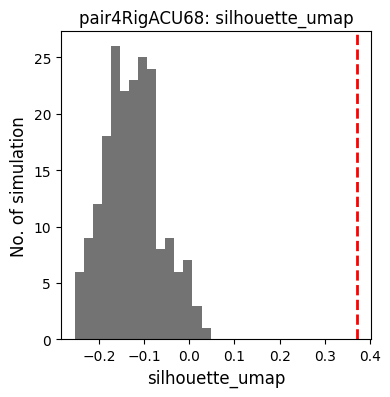

In [56]:
field = 'silhouette_umap'
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[4, 4])
d = metrics[field]
bin_width = 0.02
bins = np.arange(min(d), max(d) + bin_width, bin_width)
ax.hist(d, bins=bins, color='#737373', edgecolor='none')
# add a line for the real data
ax.axvline(x=metric_r[field][0], color='red', linestyle='--', linewidth=2)
ax.set_xlabel(field, fontsize=12)
ax.set_ylabel('No. of simulation', fontsize=12)
ax.set_title(f'{bd}: {field}', fontsize=12)
# save as pdf
fn_pdf = os.path.join(fd_save, f'random.hist.{field}.pdf')
fig.savefig(fn_pdf)

### Plot an example random embedding 

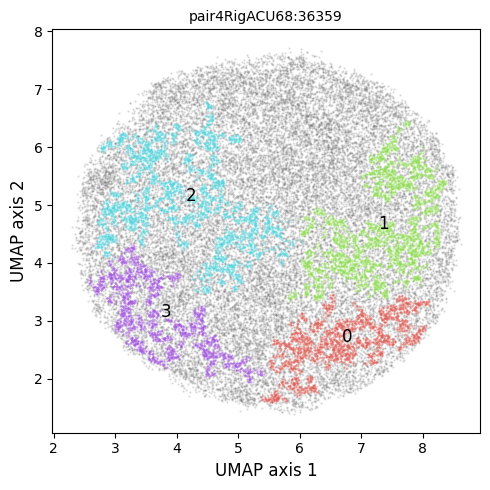

In [57]:
# color calls according to hdbscan labels
col_long = sns.color_palette('hls', n_colors=max(clusterer.labels_)+1)
# plot embedding
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[5, 5])
for hi in range(-1, max(clusterer.labels_)+1):
    idx = np.where(clusterer.labels_ == hi)[0]
    embed_s = res[idx,:]
    if hi==-1:
        ax.scatter(embed_s[:,0], embed_s[:,1], s=0.3, alpha=0.25, color='#737373')
    else:
        ax.scatter(embed_s[:,0], embed_s[:,1], s=0.3, alpha=0.5, color=col_long[hi])
        # add syl label
        ax.text(np.mean(embed_s[:,0]), np.mean(embed_s[:,1]), hi, fontsize=12)
ax.set_title(f'{bd}:{info.shape[0]}', fontsize=10)
ax.set_xlabel('UMAP axis 1', fontsize=12)
ax.set_ylabel('UMAP axis 2', fontsize=12)
plt.tight_layout()
# save fig
fn_fig = os.path.join(fd_save, f'{bd}.random.UMAPonVAE.HBBSCAN.pdf')
fig.savefig(fn_fig)

In [58]:
# save the embedding data to plot in Matlab 
embed_r = info.copy()
# save the latent features
for ii in range(latent_rd.shape[1]):
    embed_r[f'vae{ii}'] = latent_rd[:,ii]
# save the UMAP and HDBSCAN results
for ii in range(res.shape[1]):
    embed_r[f'umap{ii+1}'] = res[:,ii]
embed_r['hdbscan_cluster'] = clusterer.labels_+1
embed_r['hdbscan_prob'] = clusterer.probabilities_
fn_csv = os.path.join(fd_save, f'{bd}.random.embedding.csv')
embed_r.to_csv(fn_csv)

In [ ]:
print(fn_csv)

In [ ]:
embed_r.shape